# Initial Analysis of BIXI Data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import os
import json
import folium
from folium import plugins
import re
from haversine import haversine, Unit
from datetime import datetime, date, time
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from collections import namedtuple

In [56]:
DATA_PATH = './BixiMontrealRentals/'

#load bike ride data
def load_data():
    #loads data from all years and months into single dataframe
    df = pd.DataFrame()
    for year in range(4,10):
        for month in range(4,12):
            if month>9:
                file_loc = '%sOD_201%d-%d.csv'%(DATA_PATH,year,month)
                if year==9:
                    return df #only have data up to Sep 2019
            else:
                file_loc = '%sOD_201%d-0%d.csv'%(DATA_PATH,year,month)
            month_data = pd.read_csv(file_loc, sep=',')
            df = df.append(month_data, ignore_index=True)

raw_data = load_data()
raw_data.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member
0,2014-04-15 00:01,6209,2014-04-15 00:18,6436,1061,1
1,2014-04-15 00:01,6214,2014-04-15 00:11,6248,615,1
2,2014-04-15 00:01,6164,2014-04-15 00:18,6216,1031,1
3,2014-04-15 00:01,6214,2014-04-15 00:24,6082,1382,1
4,2014-04-15 00:02,6149,2014-04-15 00:08,6265,347,1


In [57]:
#load station data - need to look at all year's station data in case some stations were added or removed throughout the years
stations = pd.read_csv('%sStations_2014.csv'%(DATA_PATH), sep=',')

for year in range(5,10):
    station_year = pd.read_csv('%sStations_201%d.csv'%(DATA_PATH,year), sep=',')
    new_stations = station_year[~station_year['code'].isin(stations.code)]
    stations = stations.append(new_stations, ignore_index=True) #add only stations which aren't already in list

stations = stations.set_index('code')
stations.head()

,name,latitude,longitude
code,,,
6209,Milton / Clark,45.512520,-73.570620
6436,Côte St-Antoine / Clarke,45.486452,-73.595234
6214,Square St-Louis,45.517350,-73.569060
6248,St-Dominique / Rachel,45.518593,-73.581566
6164,Chambord / Laurier,45.532955,-73.584194


In [58]:
raw_data.start_date = pd.to_datetime(raw_data.start_date)
raw_data.end_date = pd.to_datetime(raw_data.end_date)
raw_data.dtypes

start_date            datetime64[ns]
start_station_code            object
end_date              datetime64[ns]
end_station_code              object
duration_sec                   int64
is_member                      int64
dtype: object

In [109]:
#merge the bike data and station tables into one
data = raw_data.merge(stations[['latitude','longitude']], how='left', left_on=['start_station_code'], right_index=True)
data = data.merge(stations[['latitude','longitude']], how='left', left_on=['end_station_code'], right_index=True, suffixes=('_start','_end'))


In [110]:
#create new columns for the day, hour, and year
def split_date(col,df):
    df['%s_day'%(col)] = df['%s_date'%(col)].apply(lambda x: x.day)
    df['%s_hour'%(col)] = df['%s_date'%(col)].apply(lambda x: x.hour)
    return df

data['year'] = data['start_date'].apply(lambda x: x.year)
data['month'] = data['start_date'].apply(lambda x: x.month)

data = split_date('start', data)
data = split_date('end', data)

data.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member,latitude_start,longitude_start,latitude_end,longitude_end,year,month,start_day,start_hour,end_day,end_hour
0,2014-04-15 00:01:00,6209,2014-04-15 00:18:00,6436,1061,1,45.512520,-73.570620,45.486452,-73.595234,2014,4,15,0,15,0
1,2014-04-15 00:01:00,6214,2014-04-15 00:11:00,6248,615,1,45.517350,-73.569060,45.518593,-73.581566,2014,4,15,0,15,0
2,2014-04-15 00:01:00,6164,2014-04-15 00:18:00,6216,1031,1,45.532955,-73.584194,45.514960,-73.585030,2014,4,15,0,15,0
3,2014-04-15 00:01:00,6214,2014-04-15 00:24:00,6082,1382,1,45.517350,-73.569060,45.550613,-73.582883,2014,4,15,0,15,0
4,2014-04-15 00:02:00,6149,2014-04-15 00:08:00,6265,347,1,45.538670,-73.569360,45.539259,-73.577338,2014,4,15,0,15,0


In [111]:
#save the combined set to pickle
data.to_pickle("../combined_data")

# Load saved combined dataframe on restart

Run first cell to import libraries and then only this cell onwards to save time. 

In [112]:
#start from here on restart of notebook - loads the combined dataset
data = pd.read_pickle("../combined_data")

# Time evolution of BIXI use

In [78]:
#station use count
station_use = data.groupby(['year','start_station_code']).size().reset_index(name='counts')
station_use.head()

,start_year,start_station_code,counts
0,2014,5002,254
1,2014,5003,202
2,2014,5004,187
3,2014,5005,475
4,2014,5006,325


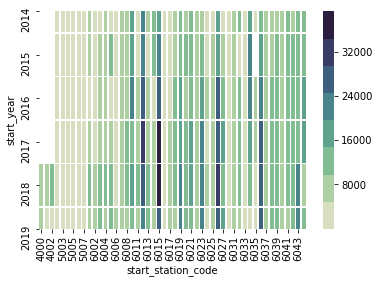

In [89]:
plot = station_use.pivot('year', 'start_station_code', 'counts')
sns.heatmap(plot.iloc[:,0:50], linewidth=0.5, cmap=sns.cubehelix_palette(8, start=.5, rot=-.75))
plt.show()

***Not an efficient way to plot since can only fit a few stations in one heatmap***

Instead: look at most popular stations regardless of year, then analyse time dependence once filter for the stations with the highest use

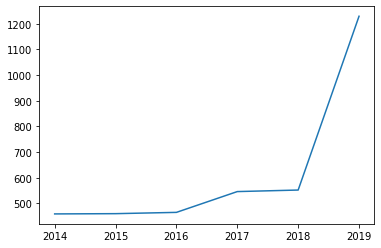

In [101]:
#number of stations
station_count = station_use.groupby('year').size().reset_index(name='num_stat')
plt.plot(station_count.start_year, station_count.num_stat)

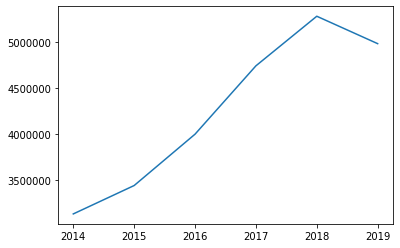

In [100]:
#total number of trips
trips = station_use.groupby('year').sum()
plt.plot(trips.index, trips.counts)

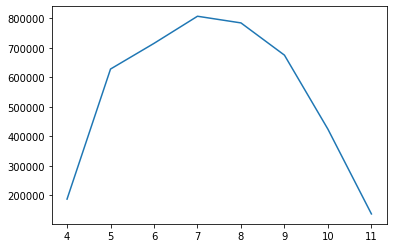

In [118]:
#use by month (averaged over the years)
monthly = data.groupby(['month','year']).size().reset_index(name='trips_per_month')
monthly = monthly[['month','trips_per_month']].groupby('month').mean()
plt.plot(monthly.index, monthly.trips_per_month)

In [ ]:
#ride duration
